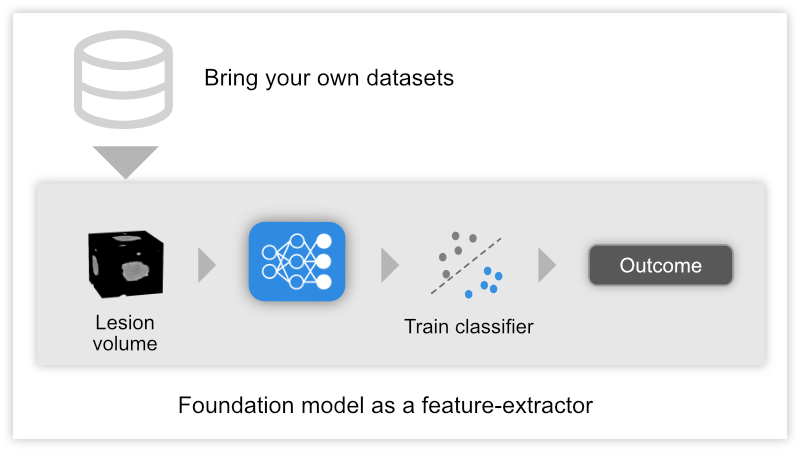

## Introduction
Suraj Pai, Dennis Bontempi, Ibrahim Hadzic, Vasco Prudente, Mateo Sokač, Tafadzwa L. Chaunzwa, Simon Bernatz, Ahmed Hosny, Raymond H Mak, Nicolai J Birkbak, Hugo JWL Aerts - *Foundation Model for Cancer Imaging Biomarkers, Nature Machine Intelligence, 2024*
https://www.nature.com/articles/s42256-024-00807-9


## Objective

This notebook is designed to guide the users toward implementing the foundation model feature-extractor pipeline on their own use-cases.

Users will be guided on the following,
1. Structuring your data for the foundation model pipeline
2. Sanity checking your data formatting
2. Preprocessing the data and extracting features from the foundation model
3. Exploratory analysis of features from the foundation model
4. Building simple classical machine learning models to predict outcomes.



## Install our `foundation-cancer-image-biomarker` package



In [ ]:
!pip install foundation-cancer-image-biomarker

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 662.6/662.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.4/180.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/

## Imports from package and general python libraries

In [ ]:
from fmcib.datasets import generate_dummy_data
from fmcib.run import get_features
from fmcib.visualization import visualize_seed_point
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

## Generate dummy data
This would be replaced by data for your use-case. We attempt to show the structure and the format your data needs to be in through our dummy data setup

In [ ]:
generate_dummy_data("data", size=100) # Generate 100 samples

2024-03-26 14:54:15.660 | INFO     | fmcib.datasets:generate_dummy_data:68 - Generated dummy data at /content/data/dummy.csv


## Inspect the dummy data format

In [ ]:
df = pd.read_csv("/content/centroid_coordinates.csv")

In [ ]:
# Replace the substring in the "image_path" column
df["image_path"] = df["image_path"].str.replace("E:\\uOttawa\\Fall'24 Co-op\\Patient 1\\_zhangjun1__0227094012\\data\\dicom\\ser010img", "/content/data/dicom/ser010img", regex=False)

In [ ]:
df.head()

,image_path,coordX,coordY,coordZ
0,/content/data/dicom/ser010img00001.dcm,-11.947618,25.973855,-143.5
1,/content/data/dicom/ser010img00002.dcm,-10.391153,29.065801,-148.5
2,/content/data/dicom/ser010img00003.dcm,-14.511099,24.084052,-153.5
3,/content/data/dicom/ser010img00004.dcm,-12.105580,22.935268,-158.5
4,/content/data/dicom/ser010img00005.dcm,-9.192142,2.491958,-163.5


In [ ]:
from google.colab import files
df.to_csv('centroid_coordinates_colab.csv', encoding = 'utf-8-sig', index=False)
files.download('centroid_coordinates_colab.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

As you can see in the dataframe structure above, the following columns are mandatory,



*   `image_path` corresponds to the full path to where the image is located.
*   `coordX`, `coordY` and `coordZ` correspond to the **global** coordinates of the seed point around which features need to be extracted.





## Loading your own data

As you can see from above, loading your own data is as simple as creating a CSV file containing the paths to your image files and their x,y,z coordinates in the global coordinate system. We use global coordinate systems so that your data can be resampled and modified without loosing track of the coordinates. If you want to convert from local to global, you can follow the code below,



```
# Convert to global coordinates
def convert_local_to_global(image_path, x, y, z):
  itk_image = sitk.ReadImage(image_path)
  x_global, y_global, z_global = itk_image.TransformContinuousIndexToPhysical[link text](https://)Point((x, y, z))
  return (x_global, y_global, z_global)

```

Once you create your CSV file, load it into a dataframe as shown above. You can follow the next set of steps either with the dummy data or bring your own data


In [ ]:
assert "image_path" in df
assert "coordX" in df
assert "coordY" in df
assert "coordZ" in df

## Visualize and verify your data
We provide a utility visualization function as a sanity check to make sure your global coordinates are placed on the image space accurately.

NOTE: Images are not re-oriented to standard space (e.g LPS), they will be in the original space they are saved in. However, as long as the image and coordinates are in the same space, our algorithm will handle these appropriately


Since version 1.3.0, affine_grid behavior has changed for unit-size grids when align_corners=True. This is not an intended use case of affine_grid. See the documentation of affine_grid for details.


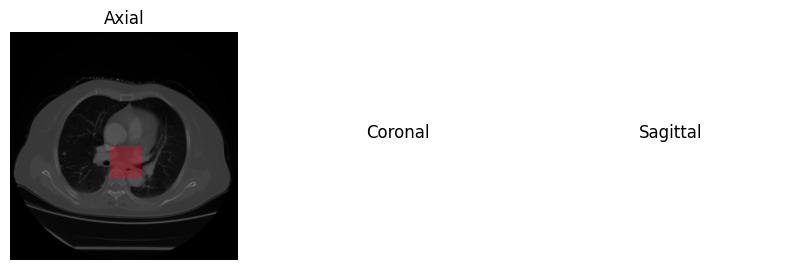

In [ ]:
row = df.iloc[0]
visualize_seed_point(row)

Double check if the annotated red dot matches the intended seed point. In case of the dummy data, it is chosen randomly and the images are also generated with random intensity so you can ignore these.

## Extract foundation model features from the CSV
Here we provide a simplified pipeline that extracts the features from the provdided dataframe.

A number of process occur in this code, which we have simplified with a single wrapper:


1.  Create a dataloader instance
2.   List item




In [ ]:
feature_df = get_features("/content/centroid_coordinates_colab.csv")

2024-09-08 12:07:43.691 | INFO     | fmcib.run:get_features:25 - Loading CSV file ...
2024-09-08 12:07:43.699 | INFO     | fmcib.preprocessing:get_dataloader:48 - Building dataloader instance ...
This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be

## Visualize features
Here we plot a histogram of the first five features across all the data samples. This provides an intuition about the feature value range and distribution



In [ ]:
feature_df.head()

,image_path,coordX,coordY,coordZ,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,...,pred_4086,pred_4087,pred_4088,pred_4089,pred_4090,pred_4091,pred_4092,pred_4093,pred_4094,pred_4095
0,/content/data/dicom/ser010img00001.dcm,-11.947618,25.973855,-143.5,1.213197,0.421063,0.467619,0.276539,1.231279,1.047429,...,0.416654,2.562520,0.546431,0.165917,0.536464,0.722795,1.549299,3.021887,1.050240,0.376569
1,/content/data/dicom/ser010img00002.dcm,-10.391153,29.065801,-148.5,1.227129,0.448926,0.451221,0.245407,1.193090,1.057539,...,0.362905,2.659950,0.625407,0.175120,0.726698,0.743715,1.519769,2.895716,1.105769,0.375580
2,/content/data/dicom/ser010img00003.dcm,-14.511099,24.084052,-153.5,1.225553,0.448681,0.471211,0.300312,1.163337,1.016179,...,0.348791,2.729368,0.600759,0.151163,0.604097,0.711473,1.528894,2.933261,0.971587,0.401674
3,/content/data/dicom/ser010img00004.dcm,-12.105580,22.935268,-158.5,1.256979,0.417794,0.490648,0.333728,1.216904,0.983727,...,0.343307,2.732709,0.644071,0.125162,0.712535,0.624451,1.575260,2.993436,0.928765,0.370153
4,/content/data/dicom/ser010img00005.dcm,-9.192142,2.491958,-163.5,1.116551,0.513310,0.494583,0.303154,1.133980,0.995036,...,0.325697,2.623749,0.629409,0.118475,0.646280,0.680700,1.574144,2.889873,0.951662,0.349966


In [ ]:
from google.colab import files
feature_df.to_csv('_zhangjun1__0227094012_features.csv', encoding = 'utf-8-sig', index=False)
files.download('_zhangjun1__0227094012_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

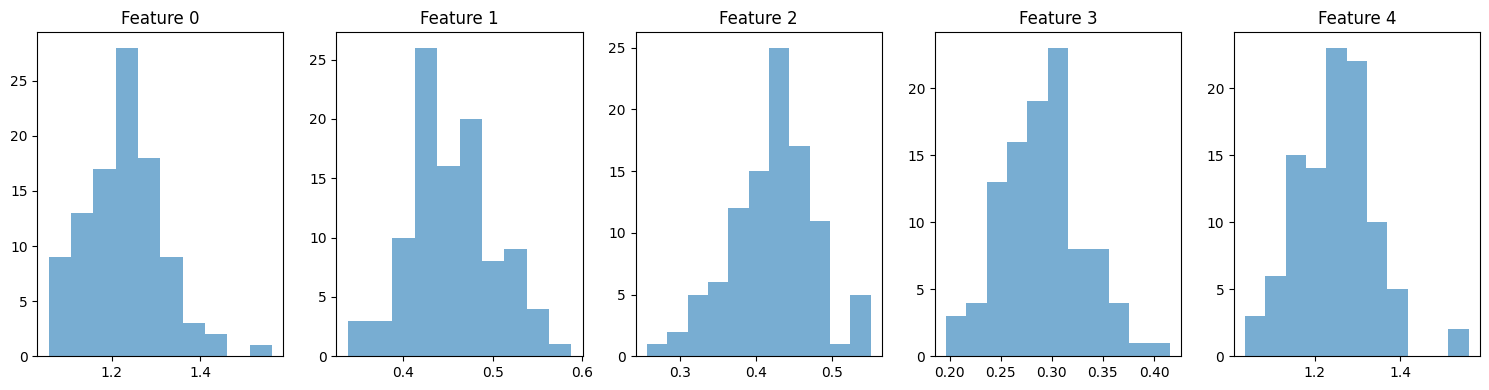

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15, 4), tight_layout=True)

for i, ax in enumerate(axs):
    ax.hist(feature_df[f"pred_{i}"], bins='auto', alpha=0.6)
    ax.set_title(f'Feature {i}')

plt.show()

In [ ]:
import os
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

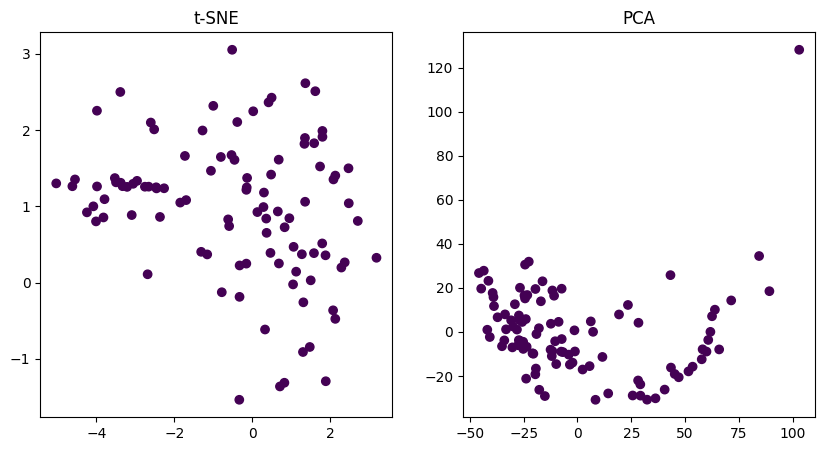

In [ ]:
features = feature_df.iloc[:, 1:].values
# Convert the features to a numpy array
features = np.array(features)

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=50)
features_tsne = tsne.fit_transform(features)

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=[0]*len(features_tsne))
plt.title('t-SNE')

plt.show()

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load a pre-trained model
model = models.resnet50(pretrained=True)
model.eval()

# Define a function to preprocess the input image
def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

# Define Smooth Guided Backpropagation
class SmoothGuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.hooks = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.gradients = output

        def backward_hook(module, grad_in, grad_out):
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_in[0]),)

        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                self.hooks.append(module.register_forward_hook(forward_hook))
                self.hooks.append(module.register_backward_hook(backward_hook))

    def generate_gradients(self, input_image, target_class):
        input_image.requires_grad = True
        output = self.model(input_image)
        self.model.zero_grad()
        target = torch.zeros(output.shape)
        target[0][target_class] = 1
        output.backward(gradient=target)
        return input_image.grad.data.numpy()[0]

# Load and preprocess the image
img_path = 'path_to_your_image.jpg'
input_image = preprocess_image(img_path)

# Initialize Smooth Guided Backpropagation
sgb = SmoothGuidedBackprop(model)

# Generate gradients
target_class = 243  # Example class index
gradients = sgb.generate_gradients(input_image, target_class)

# Visualize the saliency map
def visualize_saliency_map(gradients):
    gradients = np.transpose(gradients, (1, 2, 0))
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    plt.imshow(gradients)
    plt.axis('off')
    plt.show()

visualize_saliency_map(gradients)

## Linear Modelling
This section provides a simple workflow for building a linear model using these features. We do not elaborate on this as there are several hundreds of resources on the internet about building simple machine learning models. You are also free to use non-linear models such as RBF SVMs here.

Some useful resource can be found here: https://scikit-learn.org/stable/modules/linear_model.html, https://www.kaggle.com/code/dansbecker/your-first-machine-learning-model, https://developer.nvidia.com/blog/machine-learning-in-practice-build-an-ml-model/

In [ ]:
linear_model = LogisticRegression(C=0.001, max_iter=1000)

### Split feature dataframe into train-val-test

In [ ]:
train_df, val_test_df = train_test_split(feature_df, test_size=0.5, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))


Train size: 50
Val size: 25
Test size: 25


### Filter feature columns and select target variable
We defined the target variable in the `label` column but you are free to load it as you choose

In [ ]:
train_X = train_df[[f"pred_{idx}" for idx in range(4096)]]
val_X = val_df[[f"pred_{idx}" for idx in range(4096)]]
test_X = test_df[[f"pred_{idx}" for idx in range(4096)]]

train_y = train_df["label"]
val_y = val_df["label"]
test_y = test_df["label"]

### Training loop with simple hyperparameter search using validation set

In [ ]:
C_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
best_val_score = 0
best_model = None

for C in C_range:
    linear_model = LogisticRegression(C=C, max_iter=1000)
    linear_model.fit(train_X, train_y)
    val_pred = linear_model.predict_proba(val_X)[:, 1]
    val_score = roc_auc_score(val_y, val_pred)

    print(f"C = {C}: Validation accuracy = {val_score}")

    # Keep track of the best model
    if val_score > best_val_score:
        best_val_score = val_score
        best_model = linear_model

print(f"Best Validation accuracy: {best_val_score}")

C = 0.0001: Validation accuracy = 0.5808823529411764
C = 0.001: Validation accuracy = 0.6838235294117647
C = 0.01: Validation accuracy = 0.7205882352941176
C = 0.1: Validation accuracy = 0.6838235294117647
C = 1: Validation accuracy = 0.6617647058823529
C = 10: Validation accuracy = 0.6617647058823529
C = 100: Validation accuracy = 0.6470588235294117
Best Validation accuracy: 0.7205882352941176


### Validate on test set

In [ ]:
test_pred = best_model.predict_proba(test_X)[:, 1]
test_score = roc_auc_score(test_y, test_pred)
print(f"Score on the testing data: {test_score}")

Score on the testing data: 0.3653846153846154


## Plot ROC-Curves for train-val-test
Here we plot ROC-Curves to compare performance between train, val and test splits

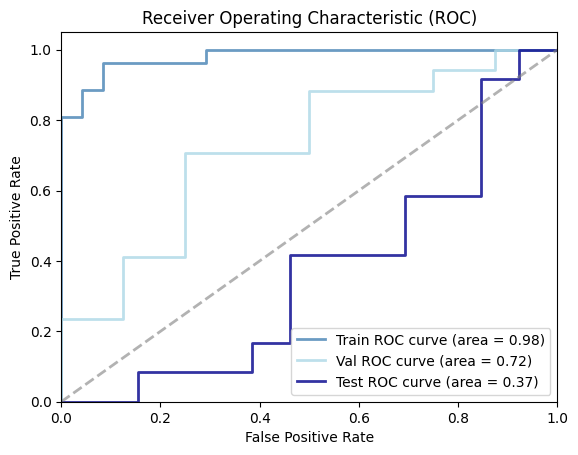

In [ ]:
plt.figure()
lw = 2


split_map = {
    "Train": [train_X, train_y, "steelblue"],
    "Val": [val_X, val_y, "lightblue"],
    "Test": [test_X, test_y, "darkblue"]
}

for split in ["Train", "Val", "Test"]:
  feats, label, color = split_map[split]
  fpr, tpr, thresholds = roc_curve(label, best_model.predict_proba(feats)[:, 1])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color=color, lw=lw, label=f'{split} ROC curve (area = %0.2f)' % roc_auc, alpha=0.8)

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()